# Titanic competition

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.stats import norm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
test_data = pd.read_csv('data/test.csv')
train_data = pd.read_csv('data/train.csv')

In [3]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Have a look at the data

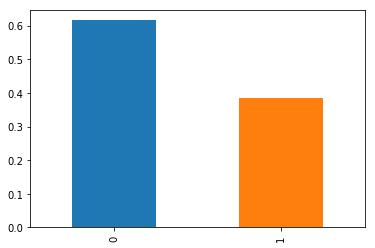

In [7]:
train_data.Survived.value_counts(normalize=True).plot(kind="bar")

0 is deceased, 1 is survived

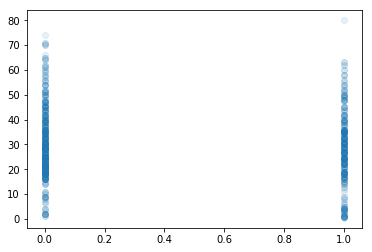

In [8]:
plt.scatter(train_data.Survived, train_data.Age, alpha=0.1)

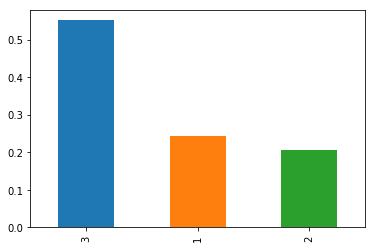

In [9]:
train_data.Pclass.value_counts(normalize=True).plot(kind="bar")

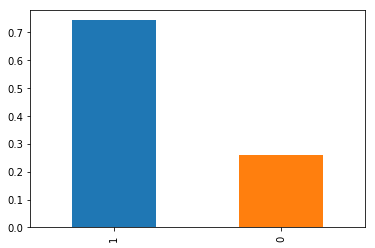

In [10]:
train_data.Survived[train_data.Sex == 'female'].value_counts(normalize=True).plot(kind="bar")

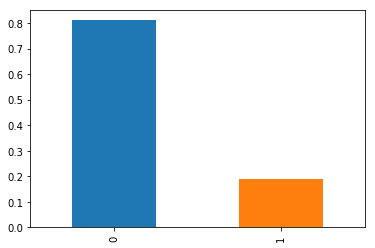

In [11]:
train_data.Survived[train_data.Sex == 'male'].value_counts(normalize=True).plot(kind="bar")

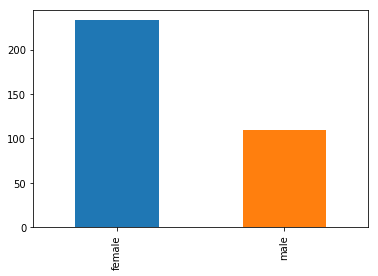

In [12]:
train_data.Sex[train_data.Survived == 1].value_counts().plot(kind="bar")

## Pre-processing data

In [13]:
def normalize_age(df):
    nans = df['Age'].isna()
    mu, sigma = norm.fit(df[-nans]['Age'])
    norm_dist = np.random.normal(mu, sigma, nans.sum())
    df.loc[nans,'Age'] = norm_dist
    df.loc[df.Age<0, 'Age'] = 0

In [14]:
normalize_age(train_data)
normalize_age(test_data)

In [15]:
# missing Fare in Test data
grouped = test_data.groupby('Pclass').mean()
grouped_fare = grouped['Fare']
test_data["Fare"] = test_data["Fare"].fillna(grouped_fare[2])


In [16]:
# as we have seen lots of values are empty
def clean_data(df):
    df.loc[df["Sex"] == "male", "Sex"] = 0
    df.loc[df["Sex"] == "female", "Sex"] = 1
    
    df["Embarked"] = df["Embarked"].fillna("S")
    df.loc[df["Embarked"] == "S", "Embarked"] = 0
    df.loc[df["Embarked"] == "C", "Embarked"] = 1
    df.loc[df["Embarked"] == "Q", "Embarked"] = 2

In [17]:
clean_data(train_data)
clean_data(test_data) 

In [18]:
def extract_title(df):
    df['Title'] = df['Name'].apply(lambda name: re.search(' ([A-Za-z]+)\.', name).group(1))

In [19]:
extract_title(train_data)
extract_title(test_data) 

In [20]:
# to do use categorical
def title_to_cat(df,test):
    df.loc[df["Title"] == "Mr", "Title"] = 0
    df.loc[df["Title"] == "Mrs", "Title"] = 1
    df.loc[df["Title"] == "Miss", "Title"] = 2
    df.loc[df["Title"] == "Master", "Title"] = 3
    df.loc[df["Title"] == "Don", "Title"] = 4
    df.loc[df["Title"] == "Rev", "Title"] = 5
    df.loc[df["Title"] == "Dr", "Title"] = 6
    df.loc[df["Title"] == "Mme", "Title"] = 7
    df.loc[df["Title"] == "Ms", "Title"] = 8
    df.loc[df["Title"] == "Major", "Title"] = 9
    df.loc[df["Title"] == "Lady", "Title"] = 10
    df.loc[df["Title"] == "Sir", "Title"] = 11
    df.loc[df["Title"] == "Mlle", "Title"] = 12
    df.loc[df["Title"] == "Col", "Title"] = 13
    df.loc[df["Title"] == "Capt", "Title"] = 14
    df.loc[df["Title"] == "Countess", "Title"] = 15
    df.loc[df["Title"] == "Jonkheer", "Title"] = 16
    if test:
        df.loc[df["Title"] == "Dona", "Title"] = 17

In [21]:
title_to_cat(train_data,False)
title_to_cat(test_data,True)

## Train / Test split

In [22]:
X = train_data[["Pclass","Age","Sex","Fare","SibSp","Parch","Embarked","Title"]].values
y = train_data["Survived"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Naive Bayes

In [23]:
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
predictions = nb.predict(X_test)
accuracy_score(y_test,predictions)

0.7094972067039106

## SVM

In [25]:
clf = SVC(gamma='auto')
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
predictions = clf.predict(X_test)
accuracy_score(y_test,predictions)

0.659217877094972

## Random forest

In [27]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
predictions = clf.predict(X_test)
accuracy_score(y_test,predictions)

0.659217877094972

## AdaBooost

In [29]:
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [30]:
predictions = clf.predict(X_test)
accuracy_score(y_test,predictions)

0.659217877094972

## Make predictions

In [31]:
X_predict = test_data[["Pclass","Age","Sex","Fare","SibSp","Parch","Embarked","Title"]]

In [32]:
results = nb.predict(X_predict)
results_df = pd.DataFrame(results,columns=["Survived"])

In [33]:
submission = pd.DataFrame()
submission["PassengerId"] = test_data["PassengerId"]
submission = pd.concat([submission,results_df], axis=1)
submission.to_csv('data/submission.csv',index=False)